In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils import data

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing,
                                              EqOddsPostprocessing,
                                              RejectOptionClassification)
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
random_state = 1

mps


pip install 'aif360[AdversarialDebiasing]'


In [2]:
# read in data and split
X = torch.load('inputs/bfw_resnet50_face_embeddings.pt').cpu()
y = torch.load('inputs/bfw_resnet50_labels.pt').cpu()
df = pd.read_csv('inputs/bfw_resnet50_df.csv')
gender = df['reference_gender']
df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
0,n004721,n004721,asian,asian,male,male,1.0
1,n004721,n004721,asian,asian,male,male,1.0
2,n004721,n004721,asian,asian,male,male,1.0
3,n004721,n004721,asian,asian,male,male,1.0
4,n004721,n004721,asian,asian,male,male,1.0
...,...,...,...,...,...,...,...
38395,n003412,n005685,white,white,male,male,0.0
38396,n008917,n008839,black,black,female,female,0.0
38397,n008452,n008150,asian,asian,male,male,0.0
38398,n004936,n002509,asian,asian,female,female,0.0


In [3]:
train_split, test_split = train_test_split(np.arange(len(X)),test_size=0.2, random_state=random_state)
train_split, val_split = train_test_split(train_split,test_size=0.25, random_state=random_state)

train_X = X[train_split]
X_val = X[val_split]
test_X = X[test_split]

train_y = y[train_split]
y_val = y[val_split]
test_y = y[test_split]

train_df = df.iloc[train_split]
val_df = df.iloc[val_split]
test_df = df.iloc[test_split]


train_gender = gender[train_split].values
train_gender[train_gender=='male'] = 0
train_gender[train_gender=='female'] = 1
train_gender = train_gender.astype(int)

gender_val = gender[val_split].values
gender_val[gender_val=='male'] = 0
gender_val[gender_val=='female'] = 1
gender_val = gender_val.astype(int)

test_gender = gender[test_split].values
test_gender[test_gender=='male'] = 0
test_gender[test_gender=='female'] = 1
test_gender = test_gender.astype(int)

In [4]:
train_matches = train_df[train_df.labels==1]
train_non_matches = train_df[train_df.labels==0]
print('non matches')
print(train_non_matches['reference_gender'].value_counts())
print('matches')
print(train_matches['reference_gender'].value_counts())

female_non_matches = train_non_matches[train_non_matches['reference_gender']=='female']
male_non_matches = train_non_matches[train_non_matches['reference_gender']=='male']

female_matches = train_matches[train_matches['reference_gender']=='female']
male_matches = train_matches[train_matches['reference_gender']=='male']

non matches
female    5804
male      5675
Name: reference_gender, dtype: int64
matches
female    5809
male      5752
Name: reference_gender, dtype: int64


In [5]:
np.random.seed(random_state)
female_matches_sub_idx = female_matches.index[np.random.choice(len(female_matches.index), size=5675, replace=False)]
male_matches_sub_idx = male_matches.index[np.random.choice(len(male_matches.index), size=5675, replace=False)]
female_non_matches_sub_idx = female_non_matches.index[np.random.choice(len(female_non_matches.index), size=5675, replace=False)]
male_non_matches_sub_idx = male_non_matches.index

X_train = torch.cat([X[female_matches_sub_idx],X[male_matches_sub_idx],X[female_non_matches_sub_idx],X[male_non_matches_sub_idx]])
y_train = torch.cat([y[female_matches_sub_idx],y[male_matches_sub_idx],y[female_non_matches_sub_idx],y[male_non_matches_sub_idx]])
gender_train = np.concatenate([gender[female_matches_sub_idx],gender[male_matches_sub_idx],gender[female_non_matches_sub_idx],gender[male_non_matches_sub_idx]])
df_train = pd.concat([df.iloc[female_matches_sub_idx],df.iloc[male_matches_sub_idx],df.iloc[female_non_matches_sub_idx],df.iloc[male_non_matches_sub_idx]])
df_train

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
17999,n000382,n000382,white,white,female,female,1.0
10563,n006634,n006634,asian,asian,female,female,1.0
17735,n001010,n001010,white,white,female,female,1.0
12546,n000460,n000460,black,black,female,female,1.0
12766,n003694,n003694,black,black,female,female,1.0
...,...,...,...,...,...,...,...
24318,n003465,n001976,asian,asian,male,male,0.0
28359,n004960,n009152,black,black,male,male,0.0
26106,n000964,n000512,white,white,male,male,0.0
26500,n009032,n005807,white,white,male,male,0.0


In [6]:
test_split, holdout_split = train_test_split(np.arange(7680),test_size=0.1, random_state=random_state)
X_test = test_X[test_split]
X_holdout = test_X[holdout_split]
y_test = test_y[test_split]
y_holdout = test_y[test_split]
gender_test = test_gender[holdout_split]
gender_holdout = test_gender[holdout_split]
df_test = test_df.iloc[test_split]
df_holdout = test_df.iloc[holdout_split]
df_holdout

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
5873,n008307,n008307,indian,indian,male,male,1.0
24669,n000806,n005599,white,white,female,female,0.0
4525,n002800,n002800,black,black,male,male,1.0
22366,n002273,n000596,black,black,female,female,0.0
19758,n003655,n002638,black,black,female,female,0.0
...,...,...,...,...,...,...,...
4412,n001280,n001280,black,black,male,male,1.0
37015,n000541,n007272,white,white,male,male,0.0
28389,n007046,n001024,indian,indian,female,female,0.0
15345,n003573,n003573,indian,indian,female,female,1.0


In [7]:
cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
def confusion_mat(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = (tn + tp)/(tn+tp+fn+fp)
    return tn, fp, fn, tp, acc
def AOE(tn_1,fp_1,fn_1,tp_1,tn_0,fp_0,fn_0,tp_0):
    tpr_1 = tp_1/(tp_1+fn_1)
    tpr_0 = tp_0/(tp_0+fn_0)

    fpr_1 = fp_1/(fp_1+tn_1)
    fpr_0 = fp_0/(fp_0+tn_0)


    return (np.abs(fpr_1-fpr_0) + np.abs(tpr_1 - tpr_0))/2

In [8]:
train_cos = cos_sim(X_train[:,:2048],X_train[:,2048:])
thresholds = np.arange(0,1.001,0.001)
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    pred = (train_cos>thresh)*1
    tn, fp, fn, tp, acc = confusion_mat(pred, y_train.numpy())
    tnr_list.append(tn/(tn+fp))
    tpr_list.append(tp/(tp+fn))
    fnr_list.append(fn/(fn+tp))
    fpr_list.append(fp/(fp+tn))
    acc_list.append(acc)


  0%|          | 0/1001 [00:00<?, ?it/s]

In [9]:
def solve(f,x):
    s = np.sign(f)
    z = np.where(s == 0)[0]
    if z:
        return z
    else:
        s = s[0:-1] + s[1:]
        z = np.where(s == 0)[0]
        return z

def interp(f,x,z):
    m = (f[z+1] - f[z]) / (x[z+1] - x[z])
    return x[z] - f[z]/m
f = np.array(fnr_list)-np.array(fpr_list)
z = solve(f,thresholds)
ans = interp(f,thresholds,z)
ans

array([0.4336875])

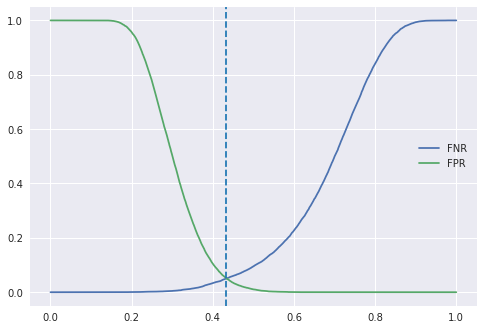

In [10]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,fnr_list,label='FNR')
    plt.plot(thresholds,fpr_list,label='FPR')
    # plt.plot(thresholds,np.array(fnr_list)-np.array(fpr_list))
    plt.axvline(x=ans,linestyle ='--')
    plt.legend()
plt.show()

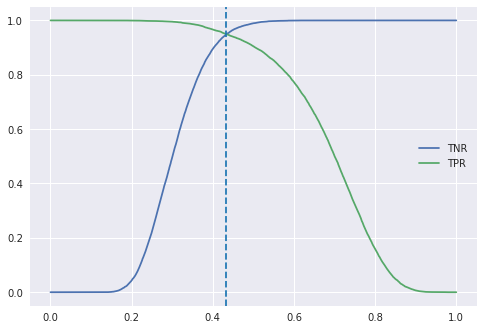

In [11]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,tnr_list,label='TNR')
    plt.plot(thresholds,tpr_list,label='TPR')
    plt.legend()
    plt.axvline(x=ans,linestyle ='--')
plt.show()

In [12]:
print(thresholds[np.abs(thresholds-ans).argmin()])
print(thresholds[acc_list == max(acc_list)])

0.434
[0.464]


In [15]:
eer_thresh = 0.438
acc_thresh = 0.46
eer_pred = (train_cos>eer_thresh)*1
acc_pred = (train_cos>acc_thresh)*1
df_bias = df_train.drop(['reference_identity','candidate_identity','reference_ethnicity','candidate_ethnicity','candidate_gender'],axis=1)
df_bias['eer_pred'] = eer_pred
df_bias['acc_pred'] = acc_pred
df_bias_female = df_bias[df_bias['reference_gender']=='female']
df_bias_male = df_bias[df_bias['reference_gender']=='male']

In [16]:
female_eer_tn, female_eer_fp, female_eer_fn, female_eer_tp, female_eer_acc = confusion_mat(df_bias_female['eer_pred'], df_bias_female['labels'])

male_eer_tn, male_eer_fp, male_eer_fn, male_eer_tp, male_eer_acc = confusion_mat(df_bias_male['eer_pred'], df_bias_male['labels'])

female_acc_tn, female_acc_fp, female_acc_fn, female_acc_tp, female_acc_acc = confusion_mat(df_bias_female['acc_pred'], df_bias_female['labels'])

male_acc_tn, male_acc_fp, male_acc_fn, male_acc_tp, male_acc_acc = confusion_mat(df_bias_male['acc_pred'], df_bias_male['labels'])

In [17]:
female_eer_tnr = female_eer_tn/(female_eer_tn+female_eer_fp)
female_eer_tpr = female_eer_tp/(female_eer_tp+female_eer_fn)
female_eer_fnr = female_eer_fn/(female_eer_fn+female_eer_tp)
female_eer_fpr = female_eer_fp/(female_eer_tn+female_eer_fp)

male_eer_tnr = male_eer_tn/(male_eer_tn+male_eer_fp)
male_eer_tpr = male_eer_tp/(male_eer_tp+male_eer_fn)
male_eer_fnr = male_eer_fn/(male_eer_fn+male_eer_tp)
male_eer_fpr = male_eer_fp/(male_eer_tn+male_eer_fp)

print(female_eer_fnr/male_eer_fnr)
print(female_eer_fpr/male_eer_fpr)
print(male_eer_tnr/female_eer_tnr)
print(male_eer_tpr/female_eer_tpr)
print((1-female_eer_acc)/(1-male_eer_acc))

1.1739634574841884
1.1376309775573585
1.0067050416208778
1.008273716120127
1.1555424394129037


In [18]:
print('female fnr:',female_eer_fnr,'male fnr:',male_eer_fnr)
print('female fpr:',female_eer_fpr,'male fpr:',male_eer_fpr)
print('female tnr:',male_eer_tnr,'male tnr:',female_eer_tnr)
print('female tpr:',male_eer_tpr,'male tpr:',female_eer_tpr)
print('female mis class:',(1-female_eer_acc),'male mis class:',(1-male_eer_acc))

female fnr: 0.052881236823612086 male fnr: 0.04504504504504504
female fpr: 0.05251221214235869 male fpr: 0.04615926708949965
female tnr: 0.9538407329105003 male tnr: 0.9474877878576413
female tpr: 0.954954954954955 male tpr: 0.9471187631763879
female mis class: 0.052696078431372584 male mis class: 0.0456028931816177


In [19]:
female_acc_tnr = female_acc_tn/(female_acc_tn+female_acc_fp)
female_acc_tpr = female_acc_tp/(female_acc_tp+female_acc_fn)
female_acc_fnr = female_acc_fn/(female_acc_fn+female_acc_tp)
female_acc_fpr = female_acc_fp/(female_acc_tn+female_acc_fp)

male_acc_tnr = male_acc_tn/(male_acc_tn+male_acc_fp)
male_acc_tpr = male_acc_tp/(male_acc_tp+male_acc_fn)
male_acc_fnr = male_acc_fn/(male_acc_fn+male_acc_tp)
male_acc_fpr = male_acc_fp/(male_acc_tn+male_acc_fp)

print(female_acc_fnr/male_acc_fnr)
print(female_acc_fpr/male_acc_fpr)
print(male_acc_tnr/female_acc_tnr)
print(male_acc_tpr/female_acc_tpr)
print((1-female_acc_acc)/(1-male_acc_acc))

1.1649601670815244
1.1226814708797632
1.0035021645384175
1.0100154596237454
1.1501694296965648


In [20]:
print('female fnr:',female_acc_fnr,'male fnr:',male_acc_fnr)
print('female fpr:',female_acc_fpr,'male fpr:',male_acc_fpr)
print('female tnr:',male_acc_tnr,'male tnr:',female_acc_tnr)
print('female tpr:',male_acc_tpr,'male tpr:',female_acc_tpr)
print('female acc:',(1-female_acc_acc),'male acc:',(1-male_acc_acc))

female fnr: 0.06605762473647224 male fnr: 0.05670376258611553
female fpr: 0.031053733426378228 male fpr: 0.027660324171952078
female tnr: 0.9723396758280479 male tnr: 0.9689462665736218
female tpr: 0.9432962374138845 male tpr: 0.9339423752635277
female acc: 0.04849439775910369 male acc: 0.04216282967275298


In [21]:
train_cos = cos_sim(X_train[:,:2048],X_train[:,2048:])
female_train_cos = train_cos[gender_train=='female']
male_train_cos = train_cos[gender_train=='male']


thresholds = np.arange(0,1.001,0.001)
female_tpr_list = []
female_tnr_list = []
female_fpr_list = []
female_fnr_list = []
female_acc_list = []

male_tpr_list = []
male_tnr_list = []
male_fpr_list = []
male_fnr_list = []
male_acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    female_pred = (female_train_cos>thresh)*1
    female_tn, female_fp, female_fn, female_tp, female_acc = confusion_mat(female_pred, y_train[gender_train=='female'].numpy())
    female_tnr_list.append(female_tn/(female_tn+female_fp))
    female_tpr_list.append(female_tp/(female_tp+female_fn))
    female_fnr_list.append(female_fn/(female_fn+female_tp))
    female_fpr_list.append(female_fp/(female_fp+female_tn))
    female_acc_list.append(female_acc)

    male_pred = (male_train_cos>thresh)*1
    male_tn, male_fp, male_fn, male_tp, male_acc = confusion_mat(male_pred, y_train[gender_train=='male'].numpy())
    male_tnr_list.append(male_tn/(male_tn+male_fp))
    male_tpr_list.append(male_tp/(male_tp+male_fn))
    male_fnr_list.append(male_fn/(male_fn+male_tp))
    male_fpr_list.append(male_fp/(male_fp+male_tn))
    male_acc_list.append(male_acc)

  0%|          | 0/1001 [00:00<?, ?it/s]

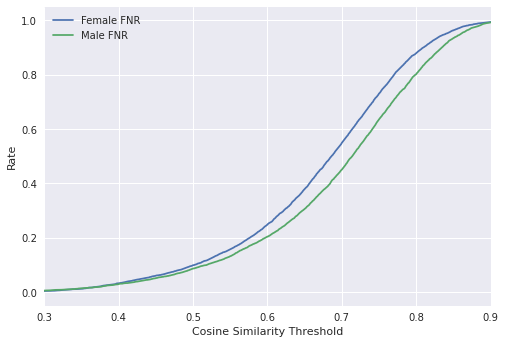

In [22]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,female_fnr_list,label='Female FNR')
    plt.plot(thresholds,male_fnr_list,label='Male FNR')
    plt.legend()
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.xlim(0.3,0.9)
plt.show()

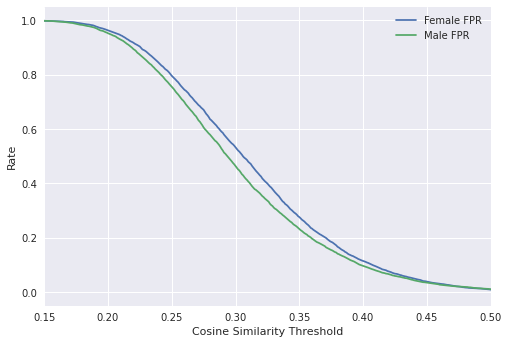

In [23]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,female_fpr_list,label='Female FPR')
    plt.plot(thresholds,male_fpr_list,label='Male FPR')
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
    plt.xlim(0.15,0.5)
plt.show()

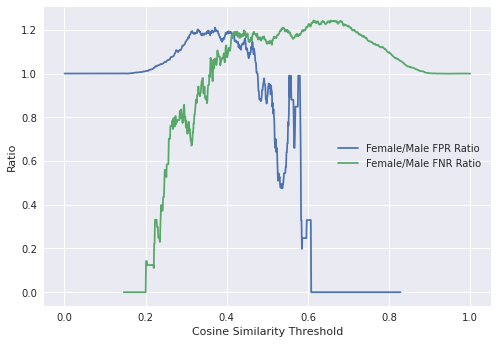

In [24]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,np.array(female_fpr_list)/np.array(male_fpr_list),label='Female/Male FPR Ratio')
    plt.plot(thresholds,np.array(female_fnr_list)/np.array(male_fnr_list),label='Female/Male FNR Ratio')
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Ratio')
    plt.legend()

plt.show()

In [25]:
len(female_fnr_list)

1001

### do all bias on validation set now

In [26]:
matches = df_val[df_val.labels==1]
non_matches = df_val[df_val.labels==0]
print(non_matches['reference_gender'].value_counts())
print(matches['reference_gender'].value_counts())

male      1914
female    1906
Name: reference_gender, dtype: int64
male      1894
female    1873
Name: reference_gender, dtype: int64


In [27]:
# bias on validation
val_cos = cos_sim(X_val[:,:2048],X_val[:,2048:])
thresholds = np.arange(0,1.001,0.001)
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    pred = (val_cos>thresh)*1
    tn, fp, fn, tp, acc = confusion_mat(pred, y_val.numpy())
    tnr_list.append(tn/(tn+fp))
    tpr_list.append(tp/(tp+fn))
    fnr_list.append(fn/(fn+tp))
    fpr_list.append(fp/(fp+tn))
    acc_list.append(acc)
f = np.array(fnr_list)-np.array(fpr_list)
z = solve(f,thresholds)
ans = interp(f,thresholds,z)
ans

  0%|          | 0/1001 [00:00<?, ?it/s]

array([0.43364922])

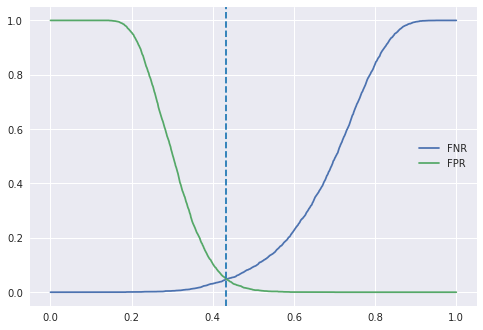

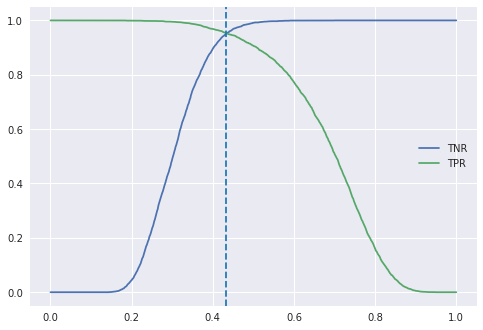

0.434
[0.453]


In [28]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,fnr_list,label='FNR')
    plt.plot(thresholds,fpr_list,label='FPR')
    # plt.plot(thresholds,np.array(fnr_list)-np.array(fpr_list))
    plt.axvline(x=ans,linestyle ='--')
    plt.legend()
plt.show()
with plt.style.context('seaborn'):    
    plt.plot(thresholds,tnr_list,label='TNR')
    plt.plot(thresholds,tpr_list,label='TPR')
    plt.legend()
    plt.axvline(x=ans,linestyle ='--')
plt.show()
print(thresholds[np.abs(thresholds-ans).argmin()])
print(thresholds[acc_list == max(acc_list)])


In [29]:
eer_thresh = 0.438
acc_thresh = 0.46
eer_pred = (val_cos>eer_thresh)*1
acc_pred = (val_cos>acc_thresh)*1
df_bias = df_val.drop(['reference_identity','candidate_identity','reference_ethnicity','candidate_ethnicity','candidate_gender'],axis=1)
df_bias['eer_pred'] = eer_pred
df_bias['acc_pred'] = acc_pred
df_bias_female = df_bias[df_bias['reference_gender']=='female']
df_bias_male = df_bias[df_bias['reference_gender']=='male']

female_eer_tn, female_eer_fp, female_eer_fn, female_eer_tp, female_eer_acc = confusion_mat(df_bias_female['eer_pred'], df_bias_female['labels'])
male_eer_tn, male_eer_fp, male_eer_fn, male_eer_tp, male_eer_acc = confusion_mat(df_bias_male['eer_pred'], df_bias_male['labels'])

female_acc_tn, female_acc_fp, female_acc_fn, female_acc_tp, female_acc_acc = confusion_mat(df_bias_female['acc_pred'], df_bias_female['labels'])
male_acc_tn, male_acc_fp, male_acc_fn, male_acc_tp, male_acc_acc = confusion_mat(df_bias_male['acc_pred'], df_bias_male['labels'])



In [30]:
female_eer_tnr = female_eer_tn/(female_eer_tn+female_eer_fp)
female_eer_tpr = female_eer_tp/(female_eer_tp+female_eer_fn)
female_eer_fnr = female_eer_fn/(female_eer_fn+female_eer_tp)
female_eer_fpr = female_eer_fp/(female_eer_tn+female_eer_fp)

male_eer_tnr = male_eer_tn/(male_eer_tn+male_eer_fp)
male_eer_tpr = male_eer_tp/(male_eer_tp+male_eer_fn)
male_eer_fnr = male_eer_fn/(male_eer_fn+male_eer_tp)
male_eer_fpr = male_eer_fp/(male_eer_tn+male_eer_fp)

print(female_eer_fnr/male_eer_fnr)
print(female_eer_fpr/male_eer_fpr)
print(male_eer_tnr/female_eer_tnr)
print(male_eer_tpr/female_eer_tpr)
print((1-female_eer_acc)/(1-male_eer_acc))

1.185558848979141
1.6736621196222456
1.023466586831767
1.0090144693009575
1.3905901032019077


In [31]:
print('female fnr:',female_eer_fnr,'male fnr:',male_eer_fnr)
print('female fpr:',female_eer_fpr,'male fpr:',male_eer_fpr)
print('female tnr:',male_eer_tnr,'male tnr:',female_eer_tnr)
print('female tpr:',male_eer_tpr,'male tpr:',female_eer_tpr)
print('female mis class:',(1-female_eer_acc),'male mis class:',(1-male_eer_acc))

female fnr: 0.05445808862786973 male fnr: 0.04593453009503696
female fpr: 0.05508919202518363 male fpr: 0.032915360501567396
female tnr: 0.9670846394984326 male tnr: 0.9449108079748164
female tpr: 0.954065469904963 male tpr: 0.9455419113721303
female mis class: 0.054776395871923844 male mis class: 0.03939075630252098


In [32]:
female_acc_tnr = female_acc_tn/(female_acc_tn+female_acc_fp)
female_acc_tpr = female_acc_tp/(female_acc_tp+female_acc_fn)
female_acc_fnr = female_acc_fn/(female_acc_fn+female_acc_tp)
female_acc_fpr = female_acc_fp/(female_acc_tn+female_acc_fp)

male_acc_tnr = male_acc_tn/(male_acc_tn+male_acc_fp)
male_acc_tpr = male_acc_tp/(male_acc_tp+male_acc_fn)
male_acc_fnr = male_acc_fn/(male_acc_fn+male_acc_tp)
male_acc_fpr = male_acc_fp/(male_acc_tn+male_acc_fp)

print(female_acc_fnr/male_acc_fnr)
print(female_acc_fpr/male_acc_fpr)
print(male_acc_tnr/female_acc_tnr)
print(male_acc_tpr/female_acc_tpr)
print((1-female_acc_acc)/(1-male_acc_acc))

1.2020066687485518
1.6555684750857889
1.0130919511911944
1.0121209446998898
1.3177275225436114


In [34]:
print('female fnr:',female_acc_fnr,'male fnr:',male_acc_fnr)
print('female fpr:',female_acc_fpr,'male fpr:',male_acc_fpr)
print('female tnr:',male_acc_tnr,'male tnr:',female_acc_tnr)
print('female tpr:',male_acc_tpr,'male tpr:',female_acc_tpr)
print('female acc:',(1-female_acc_acc),'male acc:',(1-male_acc_acc))

female fnr: 0.06727175654030966 male fnr: 0.0559662090813094
female fpr: 0.032004197271773345 male fpr: 0.019331243469174503
female tnr: 0.9806687565308255 male tnr: 0.9679958027282266
female tpr: 0.9440337909186906 male tpr: 0.9327282434596903
female acc: 0.04948399047367025 male acc: 0.03755252100840334


In [35]:
val_cos = cos_sim(X_val[:,:2048],X_val[:,2048:])
female_val_cos = val_cos[gender_val=='female']
male_val_cos = val_cos[gender_val=='male']


thresholds = np.arange(0,1.001,0.001)
female_tpr_list = []
female_tnr_list = []
female_fpr_list = []
female_fnr_list = []
female_acc_list = []

male_tpr_list = []
male_tnr_list = []
male_fpr_list = []
male_fnr_list = []
male_acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    female_pred = (female_val_cos>thresh)*1
    female_tn, female_fp, female_fn, female_tp, female_acc = confusion_mat(female_pred, y_val[gender_val=='female'].numpy())
    female_tnr_list.append(female_tn/(female_tn+female_fp))
    female_tpr_list.append(female_tp/(female_tp+female_fn))
    female_fnr_list.append(female_fn/(female_fn+female_tp))
    female_fpr_list.append(female_fp/(female_fp+female_tn))
    female_acc_list.append(female_acc)

    male_pred = (male_val_cos>thresh)*1
    male_tn, male_fp, male_fn, male_tp, male_acc = confusion_mat(male_pred, y_val[gender_val=='male'].numpy())
    male_tnr_list.append(male_tn/(male_tn+male_fp))
    male_tpr_list.append(male_tp/(male_tp+male_fn))
    male_fnr_list.append(male_fn/(male_fn+male_tp))
    male_fpr_list.append(male_fp/(male_fp+male_tn))
    male_acc_list.append(male_acc)

  0%|          | 0/1001 [00:00<?, ?it/s]

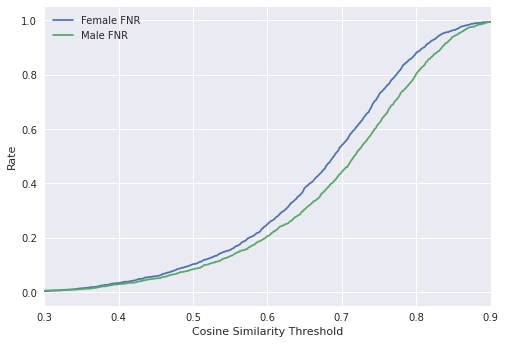

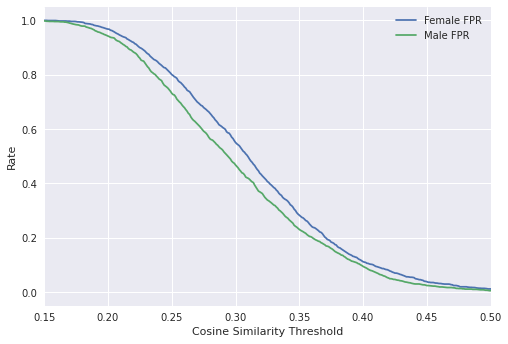

In [36]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,female_fnr_list,label='Female FNR')
    plt.plot(thresholds,male_fnr_list,label='Male FNR')
    plt.legend()
    plt.xlim(0.3,0.9)
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
plt.show()

with plt.style.context('seaborn'):    
    plt.plot(thresholds,female_fpr_list,label='Female FPR')
    plt.plot(thresholds,male_fpr_list,label='Male FPR')
    plt.legend()
    plt.xlim(0.15,0.5)
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    
plt.show()

In [37]:
matches = df_test[df_test.labels==1]
non_matches = df_test[df_test.labels==0]
print(non_matches['reference_gender'].value_counts())
print(matches['reference_gender'].value_counts())

male      1894
female    1846
Name: reference_gender, dtype: int64
male      1929
female    1919
Name: reference_gender, dtype: int64
